Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bsmrvl/DS-Unit-2-Applied-Modeling/tree/master/data/'
    !pip install category_encoders==2.*

else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder
from scipy.stats import uniform, truncnorm, randint
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [3]:
## Changing directions a bit, I'm going to try and predict occupation type from
## a variety of political questions. I'm reading these cleaned csv's from my last
## build.

AB_demo = pd.read_csv(DATA_PATH + 'AB_demo.csv').drop(columns=['Unnamed: 0','id'])
AB_opinions = pd.read_csv(DATA_PATH + 'AB_opinions.csv').drop(columns=['Unnamed: 0','id'])

In [4]:
AB_demo['occupation'].value_counts()

A housewife                                                           4133
A governmental employee                                               2165
Unemployed                                                            1757
A student                                                             1317
Private sector employee                                                940
Retired                                                                843
Owner of a shop/grocery store                                          724
Manual laborer                                                         568
Craftsperson                                                           408
Working at the armed forces or the police                              360
Professional such as lawyer, accountant, teacher, doctor, etc.         280
Agricultural worker/Owner of a farm                                    243
Employer/director of an institution with less than 10 employees        215
Director of an institutio

In [5]:
## I will remove all the "other", essentially unemployed categories,
## and group the rest into small business and government/big business

smallbiz = ['Private sector employee',
            'Owner of a shop/grocery store',
            'Manual laborer',
            'Craftsperson',
            'Professional such as lawyer, accountant, teacher, doctor, etc.',
            'Agricultural worker/Owner of a farm',
            'Employer/director of an institution with less than 10 employees'
            ]

govbigbiz = ['A governmental employee',
             'A student',
             'Working at the armed forces or the police',
             'Director of an institution or a high ranking governmental employee',
             'Employer/director of an institution with 10 employees or more'
            ]

other = ['A housewife',
         'Unemployed',
         'Retired',
         'Other'
        ]

def maketarget(cell):
    if cell in smallbiz:
        return 1
    elif cell in govbigbiz:
        return 0
    else:
        return np.NaN

In [6]:
AB_demo['occu_cat'] = AB_demo['occupation'].apply(maketarget).astype(float)

In [7]:
AB_opinions = AB_opinions.merge(AB_demo[['occu_cat']], left_index=True, right_index=True)

In [8]:
AB_opinions = AB_opinions.dropna()
AB_opinions.shape

(4555, 40)

In [9]:
## In this case, smallbiz is the positive result, but we can switch them
## above to focus on govbigbiz.

AB_opinions['occu_cat'].value_counts(normalize=True)

0.0    0.554775
1.0    0.445225
Name: occu_cat, dtype: float64

In [10]:
X = AB_opinions.drop(columns='occu_cat')
y = AB_opinions['occu_cat']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [12]:
## Now, I decided to go for *precision*. This while loop iterates 
## randomized searches until the precision for the positive target
## (which again we can switch between smallbiz and govbigbiz) is
## above .9. While loops are dangerous, of course, but I know it
## isn't hard to get above .9 in this case. I also have a np randint
## determining the seed each time, so that I can record the search seed
## which gave me the best parameters.
##
## Right now, I'm using random state 16, so that you don't have to 
## sit through the search. 

classy = XGBClassifier(
    random_state=42, 
    max_depth=2, 
)

params = {
    'subsample': truncnorm(a=0,b=1, loc=.5, scale=.1),
    'learning_rate': truncnorm(a=0,b=1, loc=.1, scale=.1),
    'scale_pos_weight': uniform(.1, .3)
}

prec = .5
recall = .05
while prec < .9 or recall < .06:
    rand_state = np.random.randint(10, 90)

    searcher = RandomizedSearchCV(
        classy, 
        params, 
        n_jobs=-1,
#         random_state=rand_state,
        random_state=16,                #### 16 for smallbiz, 25 for govbigbiz
        verbose=1,
        scoring='precision'
    )
    searcher.fit(X_train, y_train)
    model = searcher.best_estimator_
    prec = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    
# print('RANDOM STATE:',rand_state)
print(classification_report(y_test, model.predict(X_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.3s finished


              precision    recall  f1-score   support

         0.0       0.56      0.99      0.72       498
         1.0       0.90      0.07      0.12       413

    accuracy                           0.57       911
   macro avg       0.73      0.53      0.42       911
weighted avg       0.72      0.57      0.45       911



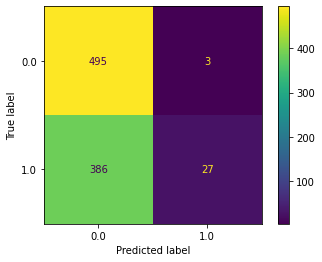

In [20]:
## Of course the recall is terrible. But we're looking for those 
## positives which our model knows almost *certainly* are positives.
## That way, we can analyze the political opinion questions which 
## most strongly determine occupation group. 

plot_confusion_matrix(model, X_test, y_test)

In [14]:
## Here's normal feature_importance_, which I won't use.

important = pd.Series(model.feature_importances_, index=X.columns)
important.sort_values(ascending=False).head()

q812a3    0.073268
q6056     0.058289
q6052     0.041897
q6087     0.041598
q6054     0.039844
dtype: float32

In [15]:
per_imps = permutation_importance(model, X_test, y_test, scoring='precision')
more_important = pd.Series(per_imps['importances_mean'], index=X.columns)

In [16]:
## Here's the top five features, calculated by permutation importances.

top5 = more_important.sort_values(ascending=False).head()
top5

q6052    0.112821
q6013    0.057937
q6105    0.039295
q6082    0.037670
q6012    0.030485
dtype: float64

In [17]:
predictions = pd.Series(model.predict(X_test), index=X_test.index, name='predictions')

In [18]:
AB_opinions = AB_opinions.merge(predictions, left_index=True, right_index=True)

In [19]:
## Here's an overview of those top 5 political questions. I'll go into
## detail in my blog.

AB_opinions[AB_opinions['predictions'] == 1][top5.index].describe()

,q6052,q6013,q6105,q6082,q6012
count,30.0,30.000000,30.000000,30.000000,30.000000
mean,-2.0,-0.866667,0.966667,-0.366667,1.433333
std,0.0,1.775957,1.245221,1.920548,1.381736
min,-2.0,-2.000000,-2.000000,-2.000000,-2.000000
25%,-2.0,-2.000000,0.000000,-2.000000,2.000000
50%,-2.0,-2.000000,1.500000,-2.000000,2.000000
75%,-2.0,1.250000,2.000000,2.000000,2.000000
max,-2.0,2.000000,2.000000,2.000000,2.000000
